Optimal Stopping Problems
===============================

> Arnav Sood (`arnav.sood@ubc.ca`). We borrow heavily from [Ben Moll's notes](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf) on this subject, as well as [Jesse Perla's](https://github.com/econtoolkit/continuous_time_methods/blob/master/optimal_stopping.pdf).

## Introduction

An optimal stopping problem is a problem that requires an agent to choose an optimal stopping time in order to maximize (or minimize) some value.

An simple example is choosing the optimal shut-down time of a factory. Given a state variable ``x_t``, continuing the plant's operations at time ``t`` gives profit ``u(x_t)`` (discounted by ``e^{-\rho t}``, with discount factor ``\rho``). Shutting down the plant (at time ``t = \tau``) stops the profit stream, but yields a one-time payoff of ``S(x_{\tau})``. We can interpret this as the value of liquidating the plant's assets and equipment.

A standard case is where ``x_t`` follows a Brownian diffusion

```math
  x_t = \mu(x_t)dt + \sigma(x_t)dW_t
```

To ensure that the plant will eventually shut down, we consider the case where ``\mu(x) < 0`` for all ``x`` (assuming that profits ``u(\cdot)`` are monotone in the state ``x_t``.)

We can consolidate the above into the following optimization problem over the stopping time ``\tau``

```math
  v(x) = \max_{\tau}\mathbb{E}_0\int_{0}^{\tau}e^{-\rho t} u(x_t)dt + e^{-\rho \tau}S(x_{\tau}),\hspace{1cm} dx_t = \mu(x_t)dt+\sigma(x_t)dt
```

## Hamilton-Jacobi-Bellman (HJB) Variational Inequality

For values of ``x`` such that the plant does not exit, we can recursively formulate the problem as

```math
  \rho v(x) = u(x) + \mu(x)v'(x) + \frac{\sigma^2(x)}{2}v''(x)
```

If the HJB equation above is unfamiliar, [Stokey and Lucas](http://www.hup.harvard.edu/catalog.php?isbn=9780674750968) is a good reference.

Define ``X`` to be the set of ``x`` for which there is no exit. Then

``x \in X: v(x)\geq S(x)\hspace{1cm} `` (i.e the value of not exiting, ``v(x)``, is at least as great as the value of exiting ``S(x)``)

``x \notin X: v(x) = S(x)\hspace{1cm}`` (i.e. the maximum possible value, ``v(x)``, is the value of choosing to exit, ``S(x)``)

That is, the partition of ``\mathbb{R}`` into ``X`` and its complement is basically a [Dedekind cut](https://en.wikipedia.org/wiki/Dedekind_cut).

This then leads to:

``x\in X: v(x)\geq S(x), \rho v(x) = u(x)+\mu(x)v'(x) +\frac{\sigma^2(x)}{2}v''(x)``

``x\notin X: v(x) = S(x), \rho v(x) \geq u(x)+\mu(x)v'(x) +\frac{\sigma^2(x)}{2}v''(x)``

This can be written compactly as a HJB variational inequality:

```math
  \min\{\rho v(x) - u(x)-\mu(x)v'(x) -\frac{\sigma^2(x)}{2}v''(x), v(x) - S(x)\} = 0
```

## Solving the HJBVI as a Linear Complementarity Problem

We can discretize the VI above as

```math
  \rho v_i^n = u_i + \mu_i(v_i^n)' + \frac{\sigma^2_i}{2}(v_i^n)''
```

Following the math at [the PDF](discretized-differential-operator-derivation.pdf), we can write this as

```math
  \rho v = u + \mu L_{1-}v + \frac{\sigma^2_i}{2}L_{2}v
```

where we've dropped the explicit vector sub/superscripts for simplicity.

Note that the move to the discrete setup requires decisions about boundary conditions. These are addressed in the package's documentation.

Combining terms, we can equivalently write the above as

```math
 \rho v = u + Av
```

where ``A`` is now simply the "differential operator," or the problem's "stochastic generator."

Hence we can rewrite the earlier HJBVI in discretized form:

```math
  \min\{\rho v - u - Av, v- S\} = 0
```

It can be shown that this problem is synonymous with

```math
  (v-S)^T(\rho v - u - Av) &= 0 \\
  v &\geq S \\
  \rho v - u - Av &\geq 0 \\
```

Noting the form of a linear complementarity problem (LCP) in the appendix, we can rewrite the above problem as follows

Denote the "excess value" ``z =  v - S``, ``B = \rho I - A``, and ``q = -u + BS``.

Then problem can be written as:

```math
  z^T(Bz + q) &= 0 \\
  z &\geq 0 \\
  Bz+q &\geq  0 \\
```

This is the standard form for LCPs (as denoted in the appendix). We can thus proceed to solve this problem, obtaining a solution ```z``, using a LCP solver. From there, we can obtain a solution to our original problem ``v = z + S``.

## Implementation

### Setup

We are given an optimal stopping problem:

```math
  v(x) = \max_{\tau}\mathbb{E}_0\int_{0}^{\tau}e^{-\rho t} u(x_t)dt + e^{-\rho \tau}S(x_{\tau}),\hspace{1cm} dx_t = \mu(x_t)dt+\sigma(x_t)dt
```

where the parameters of the stochastic process, discount factor, utility, and stopping-value are:

```math
 \mu(x) &= -0.01x \\
 \sigma^2(x) &= (0.01x)^2 \\
 S(x) &= 10 \\
 u(x) &= x^0.5 \\
 \rho &= 0.05 \\
```

We will also discretize the problem on the interval ``[0.01, 5.0]`` utilizing 300 grid points, with reflecting boundaries.

The solver we choose is [`PATHSolver.jl`](https://github.com/chkwon/PATHSolver.jl), which is the least-headache option for small (``n < 300``) problems.

To install it (along with the other dependencies), simply run

In [1]:
using Pkg
  pkg"add PATHSolver Parameters Plots"

  Updating registry at `C:\Users\Arnav Sood\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `C:\Users\Arnav Sood\.julia\environments\v1.1\Project.toml`
 [no changes]
  Updating `C:\Users\Arnav Sood\.julia\environments\v1.1\Manifest.toml`
 [no changes]


on your macOS or Windows machine. To load them, use

In [2]:
using PATHSolver, Parameters, Plots, LinearAlgebra

We also need to use the actual package

In [3]:
pkg"activate ../.."
  using SimpleDifferentialOperators

Let's codify the model's parameters

In [4]:
StoppingProblem = @with_kw (μ_bar = -0.01,
                          σ_bar = 0.01,
                          S_bar = 10.0,
                          γ = 0.5, # u(x) = x^γ
                          ρ = 0.05, # discount rate
                          x_min = 0.01,
                          x_max = 5.0,
                          M = 300) # num of grid points

#5 (generic function with 2 methods)

### Solution

Let's turn this into an LCP

In [5]:
function LCP_objects(sp)
  # setup
    @unpack μ_bar, σ_bar, S_bar, γ, ρ, x_min, x_max, M = sp
    grid = range(x_min, x_max, length = M)
    μ = μ_bar
    S(x) = S_bar
    u(x) = x^γ
    σ = σ_bar
  # construct operator
    A = μ * L₁₋(grid, (Reflecting(), Reflecting())) + σ^2/2 * L₂(grid, (Reflecting(), Reflecting()))
  # construct/return LCP objects
    B = ρ*I - A
    S_vec = S.(grid)
    q_vec = -u.(grid) + B*S_vec
    return (A = A, B = B, S = S_vec, q = q_vec)
end

LCP_objects (generic function with 1 method)

For the default case, we have

In [6]:
sp = StoppingProblem();
@unpack A, B, S, q = LCP_objects(sp);

Handing it to the solver

In [7]:
f = z -> B*z + q
n = sp.M
lb = zeros(n)
ub = 300*ones(n) # a reasonable guess?
options(convergence_tolerance = 1e-12, output = :no, time_limit = 600) # 10 minute budget
@time exit_code, sol_z, sol_f = solveLCP(f, lb, ub) # this is slower than in practice, because of choices to prioritize clarity over speed

Reading options file path.opt
 > convergence_tolerance 1.0e-12
Read of options file complete.

convergence_tolerance 1e-012
major_iteration_limit 500
minor_iteration_limit 1000
crash_iteration_limit 50
cumulative_iteration_limit 10000
time_limit 600
interrupt_limit 5
chen_lambda 0.8
output no
output_errors no
output_warnings no
output_major_iterations no
output_major_iterations_frequency 1
output_minor_iterations no
output_minor_iterations_frequency 500
output_crash_iterations no
output_crash_iterations_frequency 1
output_initial_point no
output_initial_statistics no
output_initial_point_statistics no
output_initial_scaling_statistics no
output_final_point no
output_final_statistics no
output_final_point_statistics no
output_final_scaling_statistics no
output_final_degeneracy_statistics no
output_final_summary no
output_maximum_zero_log 10
output_maximum_zero_listing 1000
output_restart_log no
output_options no
presolve yes
output_presolve_level 0
gradient_step_limit 5
gradient_searcht

(:Solved, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  33.1149, 33.1923, 33.2695, 33.3466, 33.4236, 33.5004, 33.577, 33.6528, 33.7258, 33.7858], [0.4, 0.336632, 0.291726, 0.254915, 0.222952, 0.194313, 0.168136, 0.143878, 0.121171, 0.0997492  …  -3.9968e-15, 4.44089e-15, 0.0, -4.88498e-15, -2.22045e-15, -1.33227e-15, -5.77316e-15, -2.22045e-15, -9.32587e-15, 8.88178e-16])

All that's left is to inspect the solution

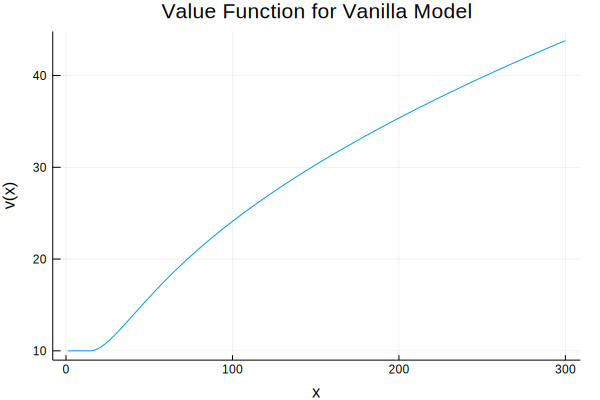

In [8]:
using Plots
v = sol_z + S
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

which passes a sanity check (i.e., monotone with a threshold).